# Classification: Cats VS Dogs

We downloaded the dataset from kaggle. The training archive contains 25,000 images of dogs and cats. 

# Using own data with included Datasets

In [14]:
import os
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import gluon
from mxnet import nd, autograd

In [2]:
def aug_transform(data, label):
    data = data.astype('float32')/255 # normalize the data
    size= 224
    aug = mx.image.ForceResizeAug((size,size)) # resize the image to 224x224
    data = aug(data)
    return data, label

In [3]:
data_folder = "data"
dataset_name = "CatsVsDogs"

training_path = os.path.join(data_folder, dataset_name)

train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(training_path,transform=aug_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Data type: <class 'numpy.float32'>
Label: 1
Label description: dog


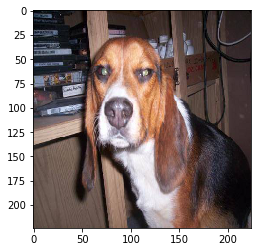

In [4]:
sample_idx = 17990
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy(), cmap='gray')
print("Data type: {}".format(data.dtype))
print("Label: {}".format(label))
print("Label description: {}".format(train_dataset.synsets[label]))
assert label == 1

# Batch size and DataLoader for train_data

In [5]:
batch_size = 64
train_data = gluon.data.DataLoader(train_dataset, batch_size, shuffle=True)

# The AlexNet architecture

In [6]:
alex_net = gluon.nn.Sequential()
with alex_net.name_scope():
    #  First convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=96, kernel_size=11, strides=(4,4), activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    #  Second convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=192, kernel_size=5, activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=(2,2)))
    # Third convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu'))
    # Fourth convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=384, kernel_size=3, activation='relu'))
    # Fifth convolutional layer
    alex_net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, activation='relu'))
    alex_net.add(gluon.nn.MaxPool2D(pool_size=3, strides=2))
    # Flatten and apply fullly connected layers
    alex_net.add(gluon.nn.Flatten())
    alex_net.add(gluon.nn.Dense(4096, activation="relu"))
    alex_net.add(gluon.nn.Dense(4096, activation="relu"))
    alex_net.add(gluon.nn.Dense(10))

# Initialize parameters

In [8]:
ctx = mx.gpu()
alex_net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

/home/ubuntu/anaconda3/envs/mxnet/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sequential0_conv0_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/home/ubuntu/anaconda3/envs/mxnet/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sequential0_conv1_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/home/ubuntu/anaconda3/envs/mxnet/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sequential0_conv2_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/home/ubuntu/anaconda3/envs/mxnet/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sequential0_conv3_bias is already initialized, ignoring. Set force_reinit=True to re

# Optimizer 

In [9]:
trainer = gluon.Trainer(alex_net.collect_params(), 'sgd', {'learning_rate': .001})

# Softmax cross-entropy loss

In [10]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# Evaluation Loop

In [ ]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for d, l in data_iterator:
        data = d.as_in_context(ctx)
        label = l.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        return acc.get()[1]

# Training loop

In [11]:
epochs = 1
smoothing_constant = .01

for e in range(epochs):
    for i, (d, l) in enumerate(train_data):
        data = d.as_in_context(ctx)
        label = l.as_in_context(ctx)
        with autograd.record():
            output = alex_net(data)
            loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(data.shape[0])
                
        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)




NameError: name 'autograd' is not defined